In [1]:
import argparse
from pathlib import Path

import numpy as np

from super_gradients.training import models
from super_gradients.training.transforms.utils import _rescale_and_pad_to_size, _rescale_xyxy_bboxes

from super_gradients.training.datasets.detection_datasets.coco_format_detection import COCOFormatDetectionDataset
from super_gradients.training.datasets.detection_datasets.doclaynet_detection import DocLayNetDetectionDataset

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

The console stream is logged into /home/marianna.parzych/sg_logs/console.log


[2024-02-06 11:44:08] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-02-06 11:44:09] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-02-06 11:44:19] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-02-06 11:44:19] WARNING - export.py - Failed to import pytorch_quantization
[2024-02-06 11:44:19] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [2]:
def box_iou_calc(boxes1, boxes2):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        boxes1 (Array[N, 4])
        boxes2 (Array[M, 4])
    Returns:
        iou (Array[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2

    This implementation is taken from the above link and changed so that it only uses numpy..
    """

    def box_area(box):
        # box = 4xn
        return (box[2] - box[0]) * (box[3] - box[1])

    area1 = box_area(boxes1.T)
    area2 = box_area(boxes2.T)

    lt = np.maximum(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = np.minimum(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

    inter = np.prod(np.clip(rb - lt, a_min=0, a_max=None), 2)
    return inter / (area1[:, None] + area2 - inter)  # iou = inter / (area1 + area2 - inter)

In [3]:
class Metrices:
    def __init__(self, classes_list: int, CONF_THRESHOLD=0.3, IOU_THRESHOLD=0.5):
        self.classes_list = classes_list
        self.num_classes = len(classes_list)
        self.CONF_THRESHOLD = CONF_THRESHOLD
        self.IOU_THRESHOLD = IOU_THRESHOLD

        self.metrices = {}

    def process_image(self, image_name, detections, labels: np.ndarray):
        """
        Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
        Arguments:
            detections (Array[N, 6]), x1, y1, x2, y2, conf, class
            labels (Array[M, 5]), class, x1, y1, x2, y2
        Returns:
            None, updates metrices accordingly
        """
        
        key_image_name = str(Path(image_name).name)
        self.metrices[key_image_name] = {
            "TP": 0,
            "FP": 0,
            "FN": 0,
            "precision": 0,
            "recall": 0,
            "f1": 0,
        }
        
        gt_classes = labels[:, 0].astype(np.int16)

        try:
            detections = detections[detections[:, 4] > self.CONF_THRESHOLD]
        except IndexError or TypeError:
            # detections are empty, end of process
            self.metrices[key_image_name]["FN"] += len(class_labels)
            return

        for class_id in range(self.num_classes):
            
            class_detections = detections[detections[:, -1] == class_id]
            class_labels = labels[labels[:, 0] == class_id]
            
            detection_classes = class_detections[:, 5].astype(np.int16)
    
            all_ious = box_iou_calc(class_labels[:, 1:], class_detections[:, :4])
            want_idx = np.where(all_ious > self.IOU_THRESHOLD)
    
            all_matches = [[want_idx[0][i], want_idx[1][i], all_ious[want_idx[0][i], want_idx[1][i]]]
                           for i in range(want_idx[0].shape[0])]
    
            all_matches = np.array(all_matches)
            if all_matches.shape[0] > 0:  # if there is match
                all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]
                true_matches = all_matches[np.unique(all_matches[:, 1], return_index=True)[1]]
                true_matches = all_matches[all_matches[:, 2].argsort()[::-1]]
                true_matches = all_matches[np.unique(all_matches[:, 0], return_index=True)[1]]

                # Convert arrays to tuples to use setdiff1d
                all_matches = [tuple(row) for row in all_matches]
                true_matches = [tuple(row) for row in true_matches]
                false_matches = np.setdiff1d(all_matches, true_matches, assume_unique=True)
                all_matches = np.array(all_matches)
                true_matches = np.array(true_matches)
                false_matches = np.array(false_matches)
            else:
                self.metrices[key_image_name]["FN"] += len(class_labels)
                self.metrices[key_image_name]["FP"] += len(class_detections)
                continue

            for i, label in enumerate(class_labels):
                if true_matches[true_matches[:, 0] == i].shape[0] == 1:  #todo this should be 0 or 1?
                    self.metrices[key_image_name]["TP"] += 1
                else:
                    self.metrices[key_image_name]["FN"] += 1
    
            self.metrices[key_image_name]["FP"] += len(false_matches)

        
        try:    
            self.metrices[key_image_name]["precision"] = self.metrices[key_image_name]["TP"] / (self.metrices[key_image_name]["TP"]+self.metrices[key_image_name]["FP"])
        except ZeroDivisionError:
            self.metrices[key_image_name]["precision"] = 0
        try:
            self.metrices[key_image_name]["recall"] = self.metrices[key_image_name]["TP"] / (self.metrices[key_image_name]["TP"]+self.metrices[key_image_name]["FN"])
        except ZeroDivisionError:
            self.metrices[key_image_name]["recall"] = 0
        try:
            self.metrices[key_image_name]["f1"] = 2 * (self.metrices[key_image_name]["precision"]*self.metrices[key_image_name]["recall"]) / (self.metrices[key_image_name]["precision"]+self.metrices[key_image_name]["recall"])
        except ZeroDivisionError:
            self.metrices[key_image_name]["f1"] = 0

In [4]:
model_type = "yolox_l"
num_classes = 17
checkpoint_path = "/path/to/ckpt_best.pth"
data_dir = "/path/to/data/dir"
images_dir = "all_images"
split_info_pth = "COCO/test.json"
# split_info_pth = "COCO/val.json"
res = 512

In [5]:
model = models.get(model_type, num_classes=num_classes, checkpoint_path=checkpoint_path)

/home/marianna.parzych/Unstructured/super-gradients-fork/src/super_gradients/common/deprecate.py:168: DeprecationWarning: Parameter `arch_params.channels_in` is deprecated since version `3.3.0` and will be removed in version `4.0.0`.
Please update your code to use the `arch_params.in_channels` instead of `arch_params.channels_in`.
  warnings.warn(message, DeprecationWarning)
[2024-02-06 11:44:23] INFO - checkpoint_utils.py - Successfully loaded model weights from /mnt/ml-team/homes/marianna.parzych/Unstructured/super-gradients-fork/checkpoints/training_new_data_from_doclaynet/RUN_20240129_122033_849622/ckpt_best.pth EMA checkpoint.


In [6]:
dataset = COCOFormatDetectionDataset(
    data_dir=data_dir,
    json_annotation_file=split_info_pth,
    images_dir=images_dir,
)

loading annotations into memory...


[2024-02-06 11:44:23] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


Done (t=0.23s)
creating index...
index created!


Indexing dataset annotations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:00<00:00, 1028.86it/s]


In [7]:
class_names = ["image", "page_number", "paraprgaphs_in_image", "paraprgaph", "subheading", "page_header", "formulas", "other", "table", "page_footer", "title", "form", "paraprgaphs_in_form", "checkbox_checked", "checkbox", "radio_button", "radio_button_checked"]

In [8]:
all_predictions = []
all_labels = []
all_names = []

In [ ]:
#for image, target, _ in dataset:
for indx in range(len(dataset)):

    image, target, name = dataset.get_named_item(indx)
    all_names.append(name)

    gt_bboxes = target[:,:4]
    gt_labels = target[:,-1]
        
    if res:
        image_input, r = _rescale_and_pad_to_size(image, (res, res))
    else:
        image_input = image
        r = None

    output = model.predict(image_input, iou=0.65, conf=0.01)
    
    labels = output.prediction.labels
    scores = output.prediction.confidence
    if r:
        bboxes = _rescale_xyxy_bboxes(output.prediction.bboxes_xyxy, 1 / r) 
    else:
        bboxes = output.prediction.bboxes_xyxy
    
    prediction = np.c_[bboxes, scores, labels]
    all_predictions.append(prediction)
    
    annos = np.c_[gt_labels, gt_bboxes]
    all_labels.append(annos)

In [ ]:
# np.save("predictions.npy", all_predictions, allow_pickle=True, fix_imports=True)
# np.save("annos.npy", all_labels, allow_pickle=True, fix_imports=True)
# np.save("names.npy", all_names, allow_pickle=True, fix_imports=True)

In [9]:
# all_predictions = np.load("predictions.npy", allow_pickle=True, fix_imports=True)
# all_labels = np.load("annos.npy", allow_pickle=True, fix_imports=True)
# all_names = np.load("names.npy", allow_pickle=True, fix_imports=True)

In [10]:
iou_thresh = 0.3
conf_thresh = 0.01
metrices = Metrices(classes_list = class_names, CONF_THRESHOLD = conf_thresh, IOU_THRESHOLD = iou_thresh)
for name, prediction, annos in zip(all_names, all_predictions, all_labels):
    metrices.process_image(name, prediction, annos)

In [ ]:
metrices.metrices

In [11]:
sorted_samples = sorted(metrices.metrices.keys(), key=lambda k: metrices.metrices[k]['f1'])

In [ ]:
len(sorted_samples)

In [ ]:
sorted_samples

In [ ]:
metrices.metrices[sorted_samples[0]]

In [ ]:
metrices.metrices[sorted_samples[-1]]

In [13]:
gt_dir = Path("/path/to/dir/with/prepared/gt/vis")
pred_dir = Path("/path/to/dir/with/prepared/pred/vis")

## --------------------------------------------------------
--------------------------------------------------------
ee5f6443-scientific_articles_64cb1b97108c66892217f8eea6ea35393680a5b37568ca5bf6ff5d.png
{'TP': 5, 'FP': 276, 'FN': 1, 'precision': 0.017793594306049824, 'recall': 0.8333333333333334, 'f1': 0.0348432055749129}

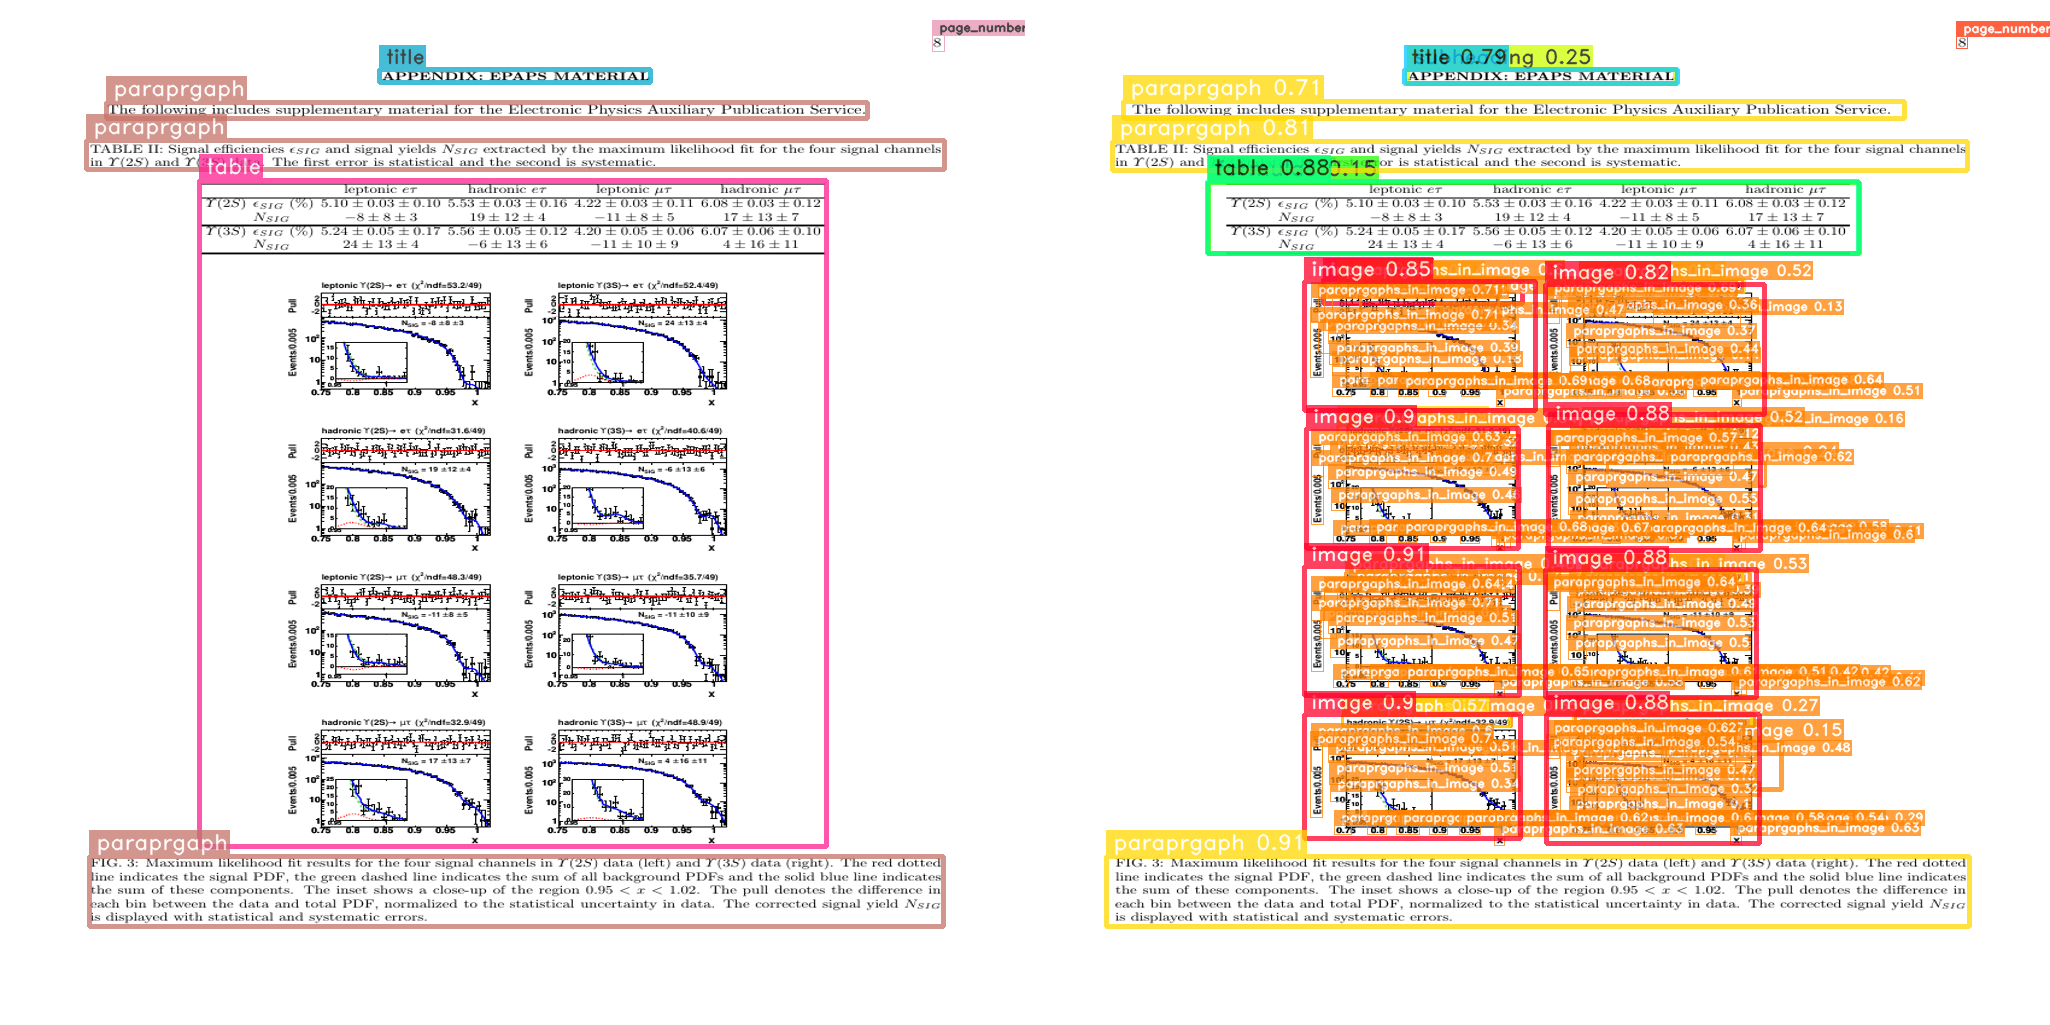

## --------------------------------------------------------
--------------------------------------------------------
b0f1d008-scientific_articles_7ac61e0b6b6a889e50c0f2fc39c144f7de78747e744ee96c722277.png
{'TP': 1, 'FP': 20, 'FN': 17, 'precision': 0.047619047619047616, 'recall': 0.05555555555555555, 'f1': 0.05128205128205128}

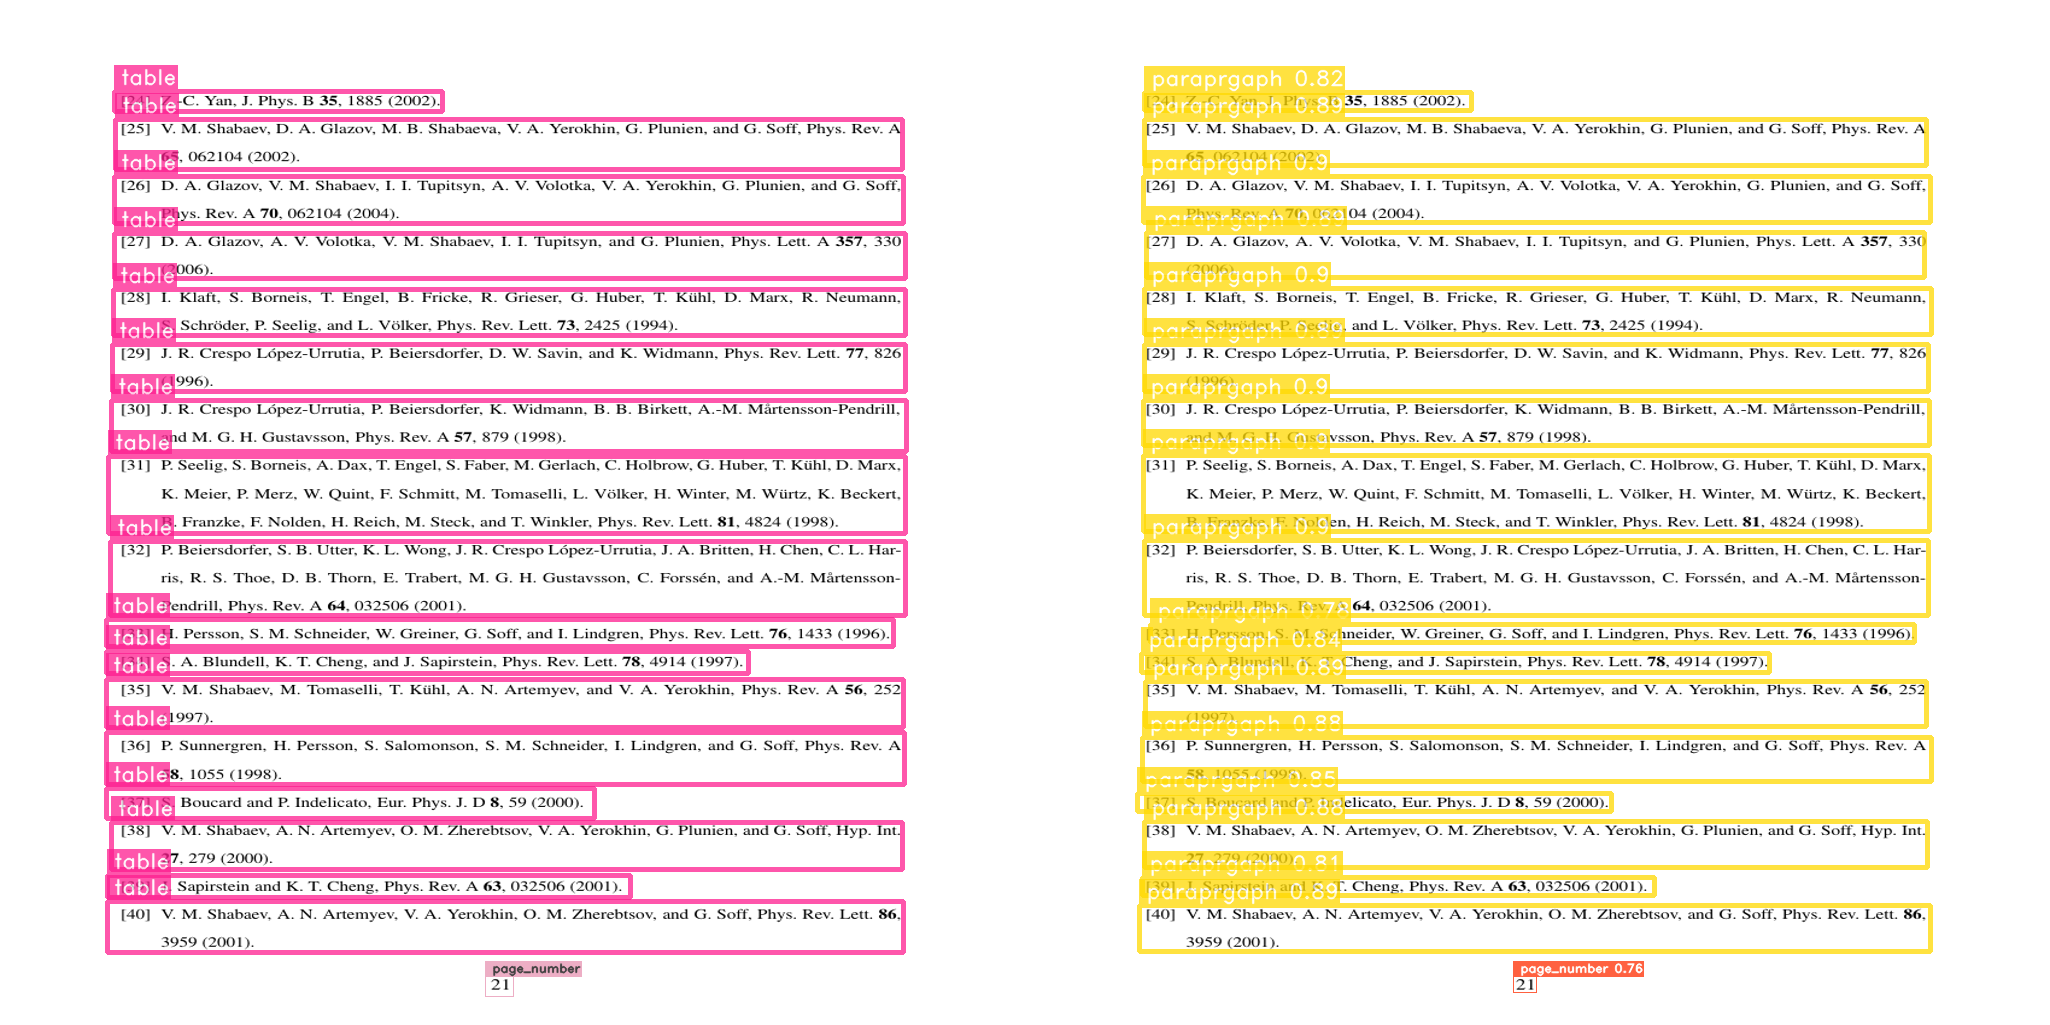

In [15]:
from IPython.display import display, Markdown
from PIL import Image

for sample in sorted_samples[:2]:  # make it bigger - 2 images as example
    text = f"--------------------------------------------------------\n--------------------------------------------------------\n{sample}\n{metrices.metrices[sample]}"
    
    gt_path = gt_dir / sample
    gt_image = Image.open(gt_path)
    pred_path = pred_dir / sample
    try:
        pred_image = Image.open(pred_path)
    except:
        pred_path = pred_dir / sample.replace(".png","_0.png")
        pred_image = Image.open(pred_path)
    concatenated_image = Image.new('RGB', (gt_image.width + pred_image.width, gt_image.height))
    concatenated_image.paste(gt_image, (0, 0))
    concatenated_image.paste(pred_image, (gt_image.width, 0))
    display(Markdown(f"## {text}"))
    display(concatenated_image)
    # print(metrices.metrices[sample])